In [1]:
import pandas as pd
import numpy as np
import os            # file operations
import requests      # networking
import zipfile
import io
from pathlib import Path


import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import wordcloud as wc

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import operator

In [2]:
!pip install wordcloud

# téléchargement de données

In [ ]:
params = dict(
    url = 'https://files.grouplens.org/datasets/movielens/ml-latest.zip',
    dirpath = './',
    timecourse = '',
    fpath = 'ml-latest.zip'
)

if not Path(params['fpath']).exists():
    r = requests.get(params['url'])
    z = zipfile.ZipFile((io.BytesIO(r.content)))
    z.extractall(path='./')

# chargement de données

In [2]:
movies = pd.read_csv("ml-latest/movies.csv")
ratings = pd.read_csv("ml-latest/ratings.csv")
tags = pd.read_csv("ml-latest/tags.csv")

In [3]:
#j'ai dimuner la taille. de 34m à 1m
ratings_trimmed = ratings[:1000000]

In [4]:
tags = tags.dropna()
tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [6]:
ratings_trimmed.shape

(1000000, 4)

In [7]:
ratings_trimmed.describe(include='all').style.highlight_null().background_gradient()

,userId,movieId,rating,timestamp
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,4844.283439,27560.680826,3.522055,1267231745.789117
std,2735.604239,49309.892237,1.061467,250538597.757449
min,1.000000,1.000000,0.500000,825431919.000000
25%,2504.000000,1220.000000,3.000000,1056437989.750000
50%,4780.000000,3263.000000,3.500000,1253985904.500000
75%,7165.000000,34338.000000,4.000000,1489871942.000000
max,9561.000000,288941.000000,5.000000,1689837984.000000


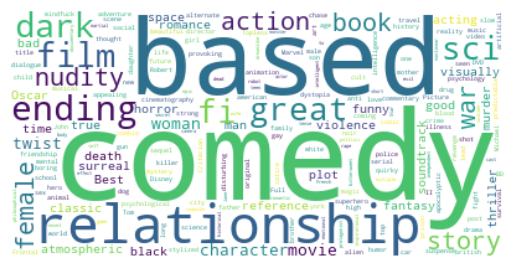

In [8]:
text = " ".join(str(cat) for cat in tags.tag)
world_cloud = wc.WordCloud(collocations = False, background_color = 'white').generate(text)
plt.imshow(world_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
genres_counts = movies['genres'].value_counts()
# Accédez au nombre de lignes avec "(no genres listed)"
no_genres_count = genres_counts.get("(no genres listed)", 0)
no_genres_count

7060

In [10]:
movies['genres'] = movies['genres'].replace('(no genres listed)', '')
movies['genres'] = movies['genres'].str.replace('|', ' ')

genres_counts = movies['genres'].value_counts()
# Accédez au nombre de lignes avec "no genres listed"
no_genres_count = genres_counts.get("(no genres listed)", 0)
no_genres_count

/tmp/ipykernel_119946/3823707196.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['genres'] = movies['genres'].str.replace('|', ' ')


0

# visualisation des données :

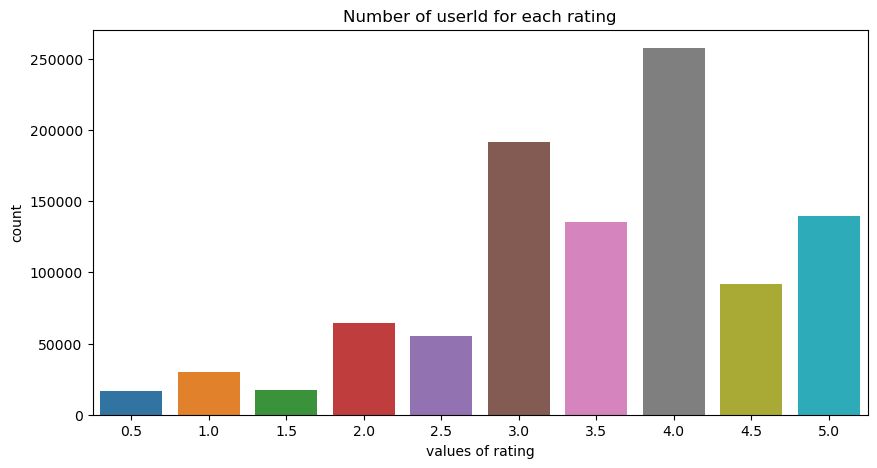

In [11]:
#grouping by number of passenger
df = ratings_trimmed.groupby("rating")["userId"].count().reset_index()

df_grouped = df.rename(columns={"userId": "count"})

#plot the count of ratings
plt.figure(figsize=(10,5))
sns.barplot(x='rating', y='count',data=df_grouped)
plt.title("Number of userId for each rating")
plt.xlabel("values of rating")
plt.ylabel("count")

plt.show()

# Combinaison des Données :

On a mergé les données des films (movies) avec les évaluations (ratings) et les tags (tags). on a utiliser le colonne movieId comme clé de fusion.

In [9]:
# Jointure des DataFrames
merged_df1 = pd.merge(movies, ratings_trimmed,on='movieId', how="inner")
merged_df = pd.merge(merged_df1, tags, on=['userId', 'movieId'], how="inner")

On a crée une nouvelle colonne, "combined_features", en combinant les informations des colonnes genres, tag, et title. on peux simplement concaténer ces informations pour créer une description complète du film.

In [17]:
# Jointure des DataFrames
merged_df1 = pd.merge(movies, ratings_trimmed,on='movieId', how="inner")
merged_df = pd.merge(merged_df1, tags, on=['userId', 'movieId'], how="inner")

#Regroupement par userId, movieId, genres, title, agrégation des tags dans une seule colonne
merged_df = merged_df.groupby(['movieId','title', 'genres','userId','rating'], as_index=False)['tag']\
                    .agg(lambda x: ', '.join(x))

#l'ajout d'une nouvelle colonne, en concatenant les informations des colonnes genres, tag, et title.
merged_df['combined_features'] = merged_df['genres'] + " " + merged_df['tag'] + " " + merged_df['title']
merged_df['combined_features'] = merged_df['combined_features'].str.replace(',', '')

In [18]:
merged_df

,movieId,title,genres,userId,rating,tag,combined_features
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,499,2.5,"animation, friendship, toys",Adventure Animation Children Comedy Fantasy an...
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1114,4.0,"animation, Disney, Pixar, toys",Adventure Animation Children Comedy Fantasy an...
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1394,5.0,"CGI, classic, disney, pixar",Adventure Animation Children Comedy Fantasy CG...
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,2483,4.0,lots of heart,Adventure Animation Children Comedy Fantasy lo...
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,2612,4.0,Tom Hanks,Adventure Animation Children Comedy Fantasy To...
...,...,...,...,...,...,...,...
10991,286107,Renfield (2023),Action Comedy Horror,8942,3.5,"dark comedy, gore, vampire",Action Comedy Horror dark comedy gore vampire ...
10992,286357,Evil Dead Rise (2023),Horror Thriller,8942,4.5,horror,Horror Thriller horror Evil Dead Rise (2023)
10993,286761,John Mulaney: Baby J (2023),Comedy,7760,4.0,"comedy, stand-up",Comedy comedy stand-up John Mulaney: Baby J (2...
10994,286897,Spider-Man: Across the Spider-Verse (2023),Action Adventure Animation Sci-Fi,9138,4.5,"action packed, animation, better than expected...",Action Adventure Animation Sci-Fi action packe...


# Traitement du Texte :

On a Appliqué des techniques de traitement du texte pour convertir la colonne combined_features en une représentation numérique. On a utilisé poue celà le TF-IDF pour attribuer des poids aux mots en fonction de leur importance relative.

In [19]:
# Créer une instance du convertisseur TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['combined_features'].values)

In [20]:
similarity_matrix = cosine_similarity(tfidf_matrix)

In [21]:
similarity_matrix.shape

(10996, 10996)

In [22]:
tfidf_matrix.shape

(10996, 11751)

# calcul de similarité :

In [23]:
def read_ratings(df):
    user_ratings = defaultdict(list)
    for index, elem in df[['userId','movieId','rating']].iterrows():
        user_ratings[int(elem['userId'])].append({index: float(elem['rating'])})        
    result = []
    for _, ratings_list in user_ratings.items():
        fusion_dict = {}
        for small_dict in ratings_list:
            fusion_dict.update(small_dict)
        result.append(fusion_dict)
    return result

In [24]:
def content_recommend(similarity_matrix, user_ratings, k):
    even_indexed_movies = {movie: rating for movie, rating in user_ratings.items() if movie % 2 == 0}
    odd_indexed_movies = {movie: 0 for movie,rating in user_ratings.items() if movie % 2 == 1}
    
    result = []
    for movie_impair in odd_indexed_movies:
        num = sum(even_indexed_movies[movie_pair] * similarity_matrix[movie_impair][movie_pair] \
                  for movie_pair in even_indexed_movies)
        den = sum(similarity_matrix[movie_impair][movie_pair] for movie_pair in even_indexed_movies)
        odd_indexed_movies[movie_impair] = num / den if den != 0 else 0
    for _ in range(k):
        if(len(odd_indexed_movies) == 0):
            break
        max_key = max(odd_indexed_movies, key=odd_indexed_movies.get)
        result.append(max_key)
        del odd_indexed_movies[max_key]
    return result

In [25]:
read_ratings(merged_df)

[{0: 2.5,
  18: 3.5,
  74: 0.5,
  105: 2.0,
  522: 2.5,
  583: 2.5,
  591: 3.0,
  617: 3.5,
  643: 2.5,
  654: 3.5,
  695: 4.5,
  719: 1.0,
  799: 3.5,
  905: 3.5,
  913: 3.0,
  1114: 2.5,
  1118: 3.5,
  1558: 5.0,
  1710: 3.5,
  1927: 2.0,
  1996: 4.5,
  2084: 2.0,
  2148: 3.5,
  2151: 2.0,
  2170: 4.0,
  2288: 4.0,
  2295: 2.0,
  2338: 4.0,
  2361: 2.5,
  2375: 3.5,
  2380: 3.0,
  2392: 2.5,
  2409: 4.0,
  2436: 3.0,
  2515: 4.0,
  2564: 4.0,
  2650: 4.0,
  2689: 2.5,
  2827: 3.0,
  2902: 3.5,
  3103: 4.5,
  3160: 3.5,
  3191: 2.5,
  3218: 2.0,
  3379: 3.5,
  3381: 2.0,
  3461: 2.0,
  3535: 1.5,
  3589: 4.0,
  3643: 4.0,
  3657: 5.0,
  3851: 4.5,
  3927: 2.0,
  4025: 3.5,
  4031: 3.0,
  4049: 4.0,
  4063: 4.5,
  4122: 4.5,
  4420: 2.5,
  4460: 1.5,
  4490: 2.0,
  4631: 1.5,
  4643: 4.0,
  4647: 2.0,
  4655: 4.0,
  4671: 4.5,
  4705: 2.5,
  4720: 2.5,
  4727: 2.5,
  4748: 4.0,
  4808: 4.5,
  4841: 3.5,
  4865: 4.0,
  4874: 2.0,
  4968: 4.5,
  4979: 3.5,
  5036: 4.5,
  5124: 2.0,
  515

In [26]:
#les films recommandé
lst = content_recommend(similarity_matrix, read_ratings(merged_df)[20], 5)

#le rating réel par l'utilisateur pour ces films recomandé
result = merged_df.iloc[lst][['userId','title','rating']]
result

,userId,title,rating
4381,8008,Bowling for Columbine (2002),5.0
5077,8008,"Good bye, Lenin! (2003)",5.0
639,8008,Mrs. Doubtfire (1993),3.5
2081,8008,Good Will Hunting (1997),5.0
3743,8008,Vatel (2000),4.5


# evaluation : 

In [27]:
#on prend tous les films notés par l'utilisateur par un rating >= 3.5
user_films_index = merged_df[(merged_df['rating'] >= 3.5) & (merged_df['userId'] == 8008)].index.tolist()

#les films qu'on lui a recomandé
film_recomande_index = result.index.tolist()

#on fait l'intersection entre les films recommandé et les films noté >=3 par cet utilisateur
intersection = set(user_films_index) & set(film_recomande_index)
nombre_films_communs = len(intersection)
print("Nombre de films recommandés et aimés par l'utilisateur:", nombre_films_communs)

#on divise le nombre de films commun sur le nombre des films recommande
#si la précision est 1, donc on a recommandé des films que l'utilisateur à déja noté >=3.5
precision = nombre_films_communs / len(film_recomande_index)
print("Précision:", precision)

Nombre de films recommandés et aimés par l'utilisateur: 5
Précision: 1.0


# user based

In [ ]:
#on crée la matrice de ratings des utilisateurs. on met 0 pour les valeurs manqués
ratings_matrix = ratings_trimmed.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
ratings_matrix

In [26]:
# d'abord, on calcule la similarité entre les utilisateurs, on utilise cosine_similarity
def similaire_user(current_user, matrix, max_users = ratings_matrix.shape[0]):
    #on prend la ligne de rating de notre utilisateur
    user = matrix[matrix.index == current_user]
    
    #on prend les lignes des autres utilisateurs
    other_users = matrix[matrix.index != current_user]
    
    #on calule la similarité de notre utilisateur et tous les autres utilisateurs
    similarities = cosine_similarity(other_users, user).tolist()
    
    #on met les index des autre utilisateurs dans une liste
    similarities_index = other_users.index.tolist()
    
    #on prend la liste des couples (index, similarity) trier par ordre croissant par la valeur similarity
    similarities_dict = sorted(dict(zip(similarities_index, similarities)).items(), key=lambda x: x[1],\
                               reverse=True)
    
    #on prend les max_users utilisateur les plus similaire au notre utilisateur
    top_users = similarities_dict[:max_users]
    
    #on prend les index des max_users utilisateur les plus similaire au notre utilisateur 
    top_users_index_final = [u[0] for u in top_users]
    
    return top_users_index_final

In [ ]:
# similar users to current_user (first value)
user_id = 8008
similar_users = similaire_user(user_id, ratings_matrix,10) 
similar_users

In [ ]:
#on calcule le mean des ratings pour chaque film pour les utilisateurs similaire.
def recommend_movies(similar_users, current_user, k ):
    
    #on prend la matrice de similarité pour les utilisateur similaire
    users = ratings_matrix[ratings_matrix.index.isin(similar_users)]
    
    
    #on prend le transpose pour avoir les userId dans les colonnes et les movieId dans les lignes
    users = users.transpose()

    #on rajoute une colonne mean pour stocker tous les moyenne de rating pour chaque film
    users['mean'] = users.mean(axis=1)
    
    #on trie la matrice par la valeur du mean, donc les plus notés seront en premier
    users_sorted = users.sort_values(by='mean', ascending=False)
    
    #on prend la ligne de rating pour notre utilisateur
    current_user = ratings_matrix[ratings_matrix.index == current_user]
    
    #on prend le transpose pour avoir les userId dans les colonnes et les movieId dans les lignes
    current_user = current_user.transpose()
    
    #on nome la colonne rating
    current_user.columns = ['rating']
    
    #on prend juste les films avec un rating 0 pour cet utilisateur.
    #On a considerer s'il donne 0 donc il a pas encore vue
    current_user = current_user[current_user.rating == 0] # unseen movies
    
    #on stocke les index des film non vue par l'utilisateur
    movies_unseen = current_user.index.tolist()
    
    #on stocke dans movies_matrix, la matrice de rating pour les films non vue
    movies_matrix = users_sorted[users_sorted.index.isin(movies_unseen)]
    
    #on prend les meilleurs k film, qui ont les plus grandes moyennes de rating
    top_movies = movies_matrix[:k]
    
    #on stocke les indices des films dans la liste top_movie_list
    top_movies_list = top_movies.index.tolist()
    movies_titles = movies[movies['movieId'].isin(top_movies_list)]
    
    return movies_titles

In [97]:
lst = recommend_movies(similar_users, user_id, 5)
lst

,movieId,title,genres
148,150,Apollo 13 (1995),Adventure Drama IMAX
600,608,Fargo (1996),Comedy Crime Drama Thriller
762,778,Trainspotting (1996),Comedy Crime Drama
1168,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action Adventure
1213,1246,Dead Poets Society (1989),Drama
